# Dance Learning: Data Exploration Notebook
### Collin Abidi
University of Pittsburgh, Deep Learning Spring 2020

In [1]:
from __future__ import print_function, division
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import math

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from matplotlib import cm
from collections import OrderedDict
from sklearn.preprocessing import normalize

%matplotlib inline

Let's load in one of the merged .json files into a dictionary to see what a typical video's pose data is like.

In [2]:
brian1 = json.loads(open("data/lisa/json/lisa_3.json").read())[:]
briandict = {frame['framenum']:frame['people'] for frame in brian1}
print("number of frames: {}".format(len(brian1)))

number of frames: 5062


Visualize one of the poses to make sure things are working properly.

According to OpenPose documentation, they should be formatted as follows:
    ```[x1,y1,c1,x2,y2,c2...]``` where `x` and `y` contain values for the body part Cartesian coordinates and `c` contains the confidence score for that body part.

In [3]:
sample_pose = briandict[50][0]['pose_keypoints_2d']

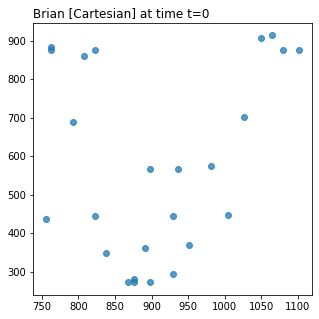

In [4]:
import matplotlib.cm as cm

coords = np.reshape(np.array(sample_pose,dtype=np.float32),(-1,3))
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
plt.title('Brian [Cartesian] at time t=0',loc='left')
c = ax.scatter(coords[:,0],coords[:,1],cmap='hsv',alpha=0.75)

Ouchie, looks like our data should be flipped. We should also convert Cartesian to Polar coordinates to make poses translation-invariant.

$
\left.\begin{matrix}
x = r\:cos\:\Theta
\\ y = r\:sin\:\Theta
\end{matrix}\right\}
P(\rho ,\Theta)\;=\;P(\sqrt[]{x^2\:+y^2},arctan(\frac{y}{x}))
$

In [2]:
def cart2pol(x, y):
    """
    Convert a Cartesian [x,y] numpy array to a polar [rho, phi] representation.
    """
    rho = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return rho, phi

def convert(coordinates):
    """
    convert from Cartesian coordinate system to polar so that
    relative position on screen doesn't matter
    input format:  [length] [x, y]
    return format: [length] [rho, phi]
    """
    center = coordinates[1,:]
    x = np.subtract(np.array(coordinates, dtype=np.float32), center)
    rho, phi = cart2pol(x[:, 0], x[:, 1])
    result = np.swapaxes(np.array([rho, phi], dtype=np.float32), 0, 1)

    # normalize rho values to range[0-1]
    result[:, 0] = normalize(result[:, 0].reshape(1, -1), norm='max')
    return result

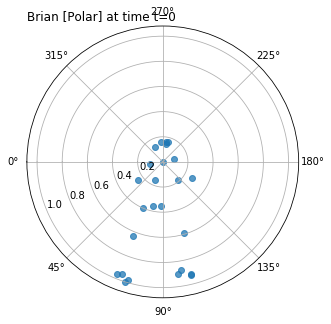

In [6]:
polar_coords = convert(coords[:,0:2])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("W")
plt.title('Brian [Polar] at time t=0',loc='left')
colors = cm.rainbow(np.linspace(0, 1, len(polar_coords[:,0])))
c = ax.scatter(polar_coords[:,1],polar_coords[:,0],cmap='hsv',alpha=0.75)

Looks like our low-confidence points are really messing up our data, so maybe we should try to remove these "jittery" frames from our dataset.

To this end, let's find frames that are "continuous" by finding the frames that have *no detected pose* or frames that have "jitter" (part confidence scores of 0).

In [3]:
# mark indices of empty and non-empty frames
def get_stability_indices(pose_dict):
    """Finds the indices of frames that are stable and have all parts present
        Args:
            pose_dict: (dict) contains the raw data from openpose from which
            pose keypoints, person id, frame number, etc. can be extracted
        Returns:
            empty,
            non_empty,
            jittery,
            non_jittery: (list) indices of frames indicating stability measures
        """
    empty = []
    non_empty = []
    for fnum, fdata in pose_dict.items():
        if len(fdata)<1:
            empty.append(fnum)
        else:
            non_empty.append(fnum)

    # find frames with jitter
    jittery = []
    non_jittery = []
    for j in non_empty:
        sample_pose = pose_dict[j][0]['pose_keypoints_2d']
        coords = np.reshape(np.array(sample_pose,dtype=np.float32),(-1,3))
        sq_sum = np.square(np.sum(coords,axis=1))
        unique, counts = np.unique(sq_sum, return_counts=True)
        if 0 in unique:
            jittery.append(j)
        else:
            non_jittery.append(j)
            
    return empty, non_empty, jittery, non_jittery

empty, non_empty, jittery, non_jittery = get_stability_indices(briandict)
print("{} / {} frames are empty".format(len(empty), len(brian1)))
print("{} / {} frames are not empty".format(len(non_empty), len(brian1)))
print("\n{} / {} frames are not empty AND jittery".format(len(jittery), len(brian1)))
print("{} / {} frames are not empty AND not jittery".format(len(non_jittery), len(brian1)))

NameError: name 'briandict' is not defined

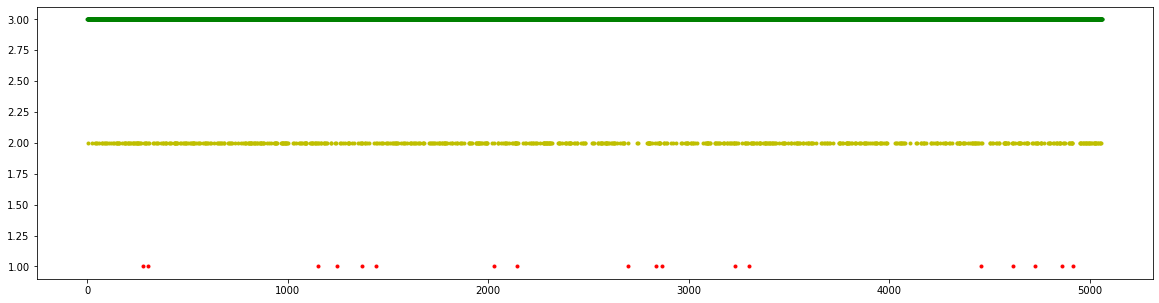

In [8]:
plt.figure(figsize=(20,5))
plt.plot(empty, [1]*len(empty),'r.')
plt.plot(jittery,[2]*len(jittery),'y.')
plt.plot(non_empty,[3]*len(non_empty),'g.')
plt.show()

It looks like both the jittery and empty frames are fairly evenly distributed throughout the dance, so we can hopefully ignore them them without worrying, although we only get about half of the data.

In [13]:
# Load in the json files for parsing
dataset = {fname:json.loads(open("data/lisa/json/"+fname).read())[:] 
           for fname in os.listdir("data/lisa/json")}
all_lens = [len(d) for d in dataset.values()]
print("All original lengths: {}\n".format(all_lens))


All original lengths: [3086, 5047, 5166, 6446, 4948, 5436, 5469, 5197, 4942, 5687, 5601, 3086, 4910, 5351, 5976, 5387, 5602, 5511, 5687, 4242, 5152, 5748, 6000, 2941, 7435, 5114, 5462, 5042, 5022, 5411, 4740, 4632, 5607, 1352, 4447, 5589, 5027, 5793, 5197, 6214, 5651, 5488, 3091, 5162, 5274, 5520, 5215, 5520, 4354, 4985, 5957, 5323, 4433, 5860, 4985, 5774, 6196, 5347, 3527, 2576, 6349, 5469, 5757, 5399, 5062, 5211, 5381, 5312, 5375, 5343, 6196, 5468, 2801, 5352, 5674, 2801, 6541, 5456, 4726, 2141, 5052, 5535]



In [14]:
# Keep track of frame metadata for use with the audio data
metadata = {}

# Count all of the non-empty and non-jittery frames across all the json files
non_empty_count, non_jittery_count = 0, 0
filenum = 0
for f, d in dataset.items():
    print("\nnumber of frames in {}: {}".format(f,len(d)))
    sub_dict = {frame['framenum']:frame['people'] for frame in d[:]}
    empty, non_empty, jittery, non_jittery = get_stability_indices(sub_dict)
    
    good_poses = np.array([sub_dict[j][0]['pose_keypoints_2d'] for j in non_jittery],dtype=np.float32)
    print("Good poses shape: {}".format(good_poses.shape))
    
    coords = np.reshape(good_poses,(-1,3))
    coords[:,0:2] = convert(coords[:,0:2])
    coords = np.reshape(coords,(-1,25,3))
    print("Post-conversion and reshaping Coords shape: {}".format(coords.shape))
    
    # save the frame metadata for later usage
    metadata[f] = {"non_jittery":non_jittery,"empty":empty,"non_empty":non_empty,"jittery":jittery}
    
    # split all the samples
    for i in range(0,len(coords[:,:,0]-16),16):
        np.save("data/lisa/poses/lisa_"+str(filenum)+"_"+str(int(i/16)),coords[i:i+16,:,0:2])
    filenum += 1



number of frames in 'ANPANMAN' & 'Airplane Pt.json: 3086
Good poses shape: (1948, 75)
Post-conversion and reshaping Coords shape: (1948, 25, 3)

number of frames in CLC (씨엘씨) _ BLACK DRESS _ Lisa Rhee Dance Cover-gcwpTwYK43w.json: 5047
Good poses shape: (3163, 75)
Post-conversion and reshaping Coords shape: (3163, 25, 3)

number of frames in lisa_2036.json: 5166
Good poses shape: (3010, 75)
Post-conversion and reshaping Coords shape: (3010, 25, 3)

number of frames in lisa_2000.json: 6446
Good poses shape: (3241, 75)
Post-conversion and reshaping Coords shape: (3241, 25, 3)

number of frames in lisa_2050.json: 4948
Good poses shape: (3974, 75)
Post-conversion and reshaping Coords shape: (3974, 25, 3)

number of frames in lisa_2003.json: 5436
Good poses shape: (3677, 75)
Post-conversion and reshaping Coords shape: (3677, 25, 3)

number of frames in DIA (다이아) - Can't Stop (듣고싶어) - Lisa Rhee Dance Cover-XnMtkBnRKgs.json: 5469
Good poses shape: (3649, 75)
Post-conversion and reshaping Coo

In [12]:
# save metadata to json too
json = json.dumps(metadata)
f = open("data/ellen_and_brian/final_data/ellen/metadata.json","w")
f.write(json)
f.close()

# Extracting the Audio Data
I already converted the .mp4 files to .mp3 using ffmpeg, so we will use a function to decode the audio into numpy arrays.

In [9]:
import subprocess
import sys
from scipy.io import wavfile
import librosa
import librosa.display

def decode (fpath):
    sr, x = wavfile.read(fpath)
    return sr, x

In [10]:
def normalize_audio(x):
    x = np.array(x, dtype=np.float32)
    normalized_a = np.array(x[:,0]-min(x[:,0])) / np.array(max(x[:,0])-min(x[:,0]))
    normalized_b = np.array(x[:,1]-min(x[:,1])) / np.array(max(x[:,1])-min(x[:,1]))
    return np.swapaxes(np.vstack((normalized_a, normalized_b)), 0, 1)

Test extracting and normalizing the audio on `ellen_12.wav`.

In [29]:
e_fr, e_x = decode("data/ellen_and_brian/ellen_audio/ellen_12.wav")
e_x_norm = normalize_audio(e_x)
print(e_x.shape[0] / e_fr)
print(e_x.shape)

97.15229024943311
(4284416, 2)


(64, 5830)


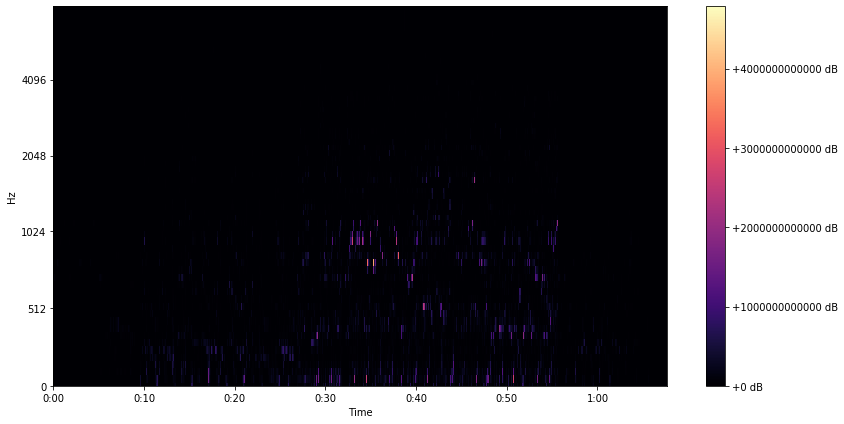

In [47]:
S_0 = librosa.feature.melspectrogram(y=np.array(e_x[:,0],dtype=np.float32), sr=e_fr, n_mels=64,fmax=8000, hop_length=735)
S_dB_0 = librosa.power_to_db(S_0, ref=np.max)
print(S_0.shape)
plt.figure(figsize=(12,6))
plt.clf()
librosa.display.specshow(S_0, x_axis='time', y_axis='mel', sr=e_fr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

(64, 5830)


<Figure size 432x288 with 0 Axes>

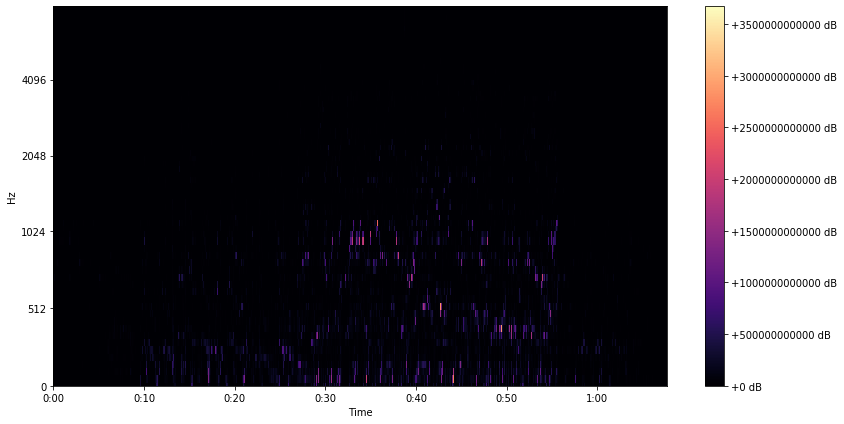

In [49]:
S_1 = librosa.feature.melspectrogram(y=np.array(e_x[:,1],dtype=np.float32), sr=e_fr, n_mels=64,fmax=8000, hop_length=735)
S_dB_1 = librosa.power_to_db(S_1, ref=np.max)
print(S_1.shape)
plt.clf()
plt.figure(figsize=(12,6))
librosa.display.specshow(S_1, x_axis='time', y_axis='mel', sr=e_fr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(12,6))
librosa.display.specshow(S_1 - S_0, x_axis='time', y_axis='mel', sr=e_fr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

## Slicing the correct indices from the audio

When we're sampling frames from the video, we sample at 30 frames / second (30 Hz).

When we're sampling audio from the video, we sample at 44,100 samples / second ( 44.1 KHz).

$\frac{44,100\:samples}{1\:second}\;*\;\frac{1\:second}{30\:frames}\;=\;1,470\;\frac{samples}{frame}$

However, some videos are 60 fps, so we will change the sampling rate to 735 for 30 fps videos.

$\frac{44,100\:samples}{1\:second}\;*\;\frac{1\:second}{60\:frames}\;=\;735\;\frac{samples}{frame}$

In [11]:
def extract_good_audio(audio, sr_audio, frame_indices, sr_frames):
    samples_per_frame = int(sr_audio / sr_frames)
    print("Samples per frame: {}".format(samples_per_frame))
    audio_indices = [f * samples_per_frame for f in frame_indices]    
    print("Original audio shape: {}".format(audio.shape))
    # if the video has 30 fps, we need to reduce the sampling area
    if sr_frames == 30:
        good_audio = np.array([audio[i:i+int(samples_per_frame),:] for i in audio_indices])
    elif sr_frames == 25:
        good_audio = np.array([audio[i:i+int(samples_per_frame),:] for i in audio_indices])
    elif sr_frames == 24:
        good_audio = np.array([audio[i:i+int(samples_per_frame),:] for i in audio_indices])
    else:
        good_audio = np.array([audio[i:i+int(samples_per_frame),:] for i in audio_indices])
        
    print("good audio shape: {}".format(good_audio.shape))
    good_audio = np.reshape(good_audio, (-1, 2))

    S_0 = librosa.feature.melspectrogram(y=np.array(good_audio[:,0],dtype=np.float32), sr=sr_audio, n_mels=64, fmax=8000, hop_length=1920)
    #S_0_dB = librosa.power_to_db(S_0, ref=np.max)
    S_1 = librosa.feature.melspectrogram(y=np.array(good_audio[:,1],dtype=np.float32), sr=sr_audio, n_mels=64, fmax=8000, hop_length=1920)
    #S_1_dB = librosa.power_to_db(S_1, ref=np.max)
    
    return good_audio, np.swapaxes(np.array([S_0,S_1],dtype=np.float32),0,2)

# Creating audio dataset
Let's follow the dataset saving procedure we did before with the poses and create a numpy file for all of the audio in the dataset.

In [16]:
import cv2

filepath = "data/lisa/original_audio/"
full_audio = np.empty([1, 735, 2])
hop_length = 735

filenum = 0
for fname in metadata.keys():
    print("Decoding {}".format(fname))
    if 'merged_' in fname:        
        sr, x = decode(filepath + fname.split('.')[0][7:]+ ".wav")
    else:
        sr, x = decode(filepath + fname.split('.')[0]+ ".wav")
    #video = cv2.VideoCapture("../openpose/videos/"+fname+".*");
    #fps = video.get(cv2.CAP_PROP_FPS)
    #print("FPS: {}".format(fps))
    print("sr: {}".format(sr))
    a, spectrodata = extract_good_audio(x, sr, metadata[fname]['non_jittery'], 25)
    print("spectroshape: {}\n".format(spectrodata.shape))
    
    for i in range(16,spectrodata.shape[0]-32,16):
        np.save("data/lisa/audio/lisa_"+str(filenum)+"_"+str(int((i-16)/16)),spectrodata[i-8:i+24,:,:])
    filenum += 1


Decoding 'ANPANMAN' & 'Airplane Pt.json
sr: 48000
Samples per frame: 1920
Original audio shape: (6178864, 2)
good audio shape: (1948, 1920, 2)
spectroshape: (1949, 64, 2)

Decoding CLC (씨엘씨) _ BLACK DRESS _ Lisa Rhee Dance Cover-gcwpTwYK43w.json
sr: 48000
Samples per frame: 1920
Original audio shape: (10104894, 2)
good audio shape: (3163, 1920, 2)
spectroshape: (3164, 64, 2)

Decoding lisa_2036.json
sr: 48000
Samples per frame: 1920
Original audio shape: (9919320, 2)
good audio shape: (3010, 1920, 2)
spectroshape: (3011, 64, 2)

Decoding lisa_2000.json
sr: 48000
Samples per frame: 1920
Original audio shape: (12376920, 2)
good audio shape: (3241, 1920, 2)
spectroshape: (3242, 64, 2)

Decoding lisa_2050.json
sr: 48000
Samples per frame: 1920
Original audio shape: (9906502, 2)
good audio shape: (3974, 1920, 2)
spectroshape: (3975, 64, 2)

Decoding lisa_2003.json
sr: 48000
Samples per frame: 1920
Original audio shape: (10437589, 2)
good audio shape: (3677, 1920, 2)
spectroshape: (3678, 64,

## For each frame of the pose data, there is now a `735 x 2` slice of normalized audio

In [35]:
spectrodata[100-8:100+24,:,:].shape

(24, 64, 4)

### Dataset template

In [44]:
class DanceDataset(Dataset):
    def __init__(self, root_dir, sequence_length, gpu_mode=False, transform=None):
        """Initializes a dataset containing sequences of skeletons and audio
        Args:
            root_dir (string): path to the directory containing json files
            and the properly formatted audio
            sequence_length (int): length of each sequence, in frames
        """
        self.root_dir = root_dir
        self.transform = transform
        self.files = os.listdir(self.root_dir)
        self.sequence_length = sequence_length
        self.total_len = 0
        self.metadata = None
        
    def get_stable_frames(self, pose_dict):
        """Finds the indices of frames that are stable and have all parts present
        Args:
            pose_dict: (dict) contains the raw data from openpose from which
            pose keypoints, person id, frame number, etc. can be extracted
        Returns:
            non_empty: (list) indices of frames with all parts present
            non_jittery: (list) indices of frames with most parts present
        """
        empty = []
        non_empty = []
        for fnum, fdata in pose_dict.items():
            if len(fdata)<1:
                empty.append(fnum)
            else:
                non_empty.append(fnum)

        # Go through each frame's pose data and find any with confidence scores of 0
        # which will be flagged as "jittery" frames
        jittery = []
        non_jittery = []
        for j in non_empty:
            sample_pose = pose_dict[j][0]['pose_keypoints_2d']
            coords = np.reshape(np.array(sample_pose,dtype=np.float32),(-1,3))
            sq_sum = np.square(np.sum(coords,axis=1))
            unique, counts = np.unique(sq_sum, return_counts=True)
            if 0 in unique:
                jittery.append(j)
            else:
                non_jittery.append(j)
                
        print("{} / {} frames are not empty".format(len(non_empty), len(pose_dict)))
        print("{} / {} frames are not empty AND not jittery\n".format(len(non_jittery), len(pose_dict)))

        return non_empty, non_jittery
                
    def __len__(self):
        """Returns the size of the dataset"""
        
        # See if we've already done this
        if self.total_len == 0:
            # Load in the json files for parsing
            dataset = {fname:json.loads(open(self.root_dir + "/" + fname).read())[:] 
                       for fname in self.files}
            all_lens = [len(d) for d in dataset.values()]
            print("All original lengths: {}\n".format(all_lens))

            # Count all of the non-empty and non-jittery frames across all the json files
            non_empty_count, non_jittery_count = 0, 0
            for f, d in dataset.items():
                print("number of frames in {}: {}".format(f,len(d)))
                sub_dict = {frame['framenum']:frame['people'] for frame in d[:]}
                nempty, njittery = self.get_stable_frames(sub_dict)
                non_empty_count += len(nempty)
                non_jittery_count += len(njittery)
                
                print("Current metadata: {}".format(self.metadata))
                # add indexing data to metadata structure
                if self.metadata is None:
                    self.metadata = [[f, 0, len(nempty)-1]]
                else:
                    self.metadata.append([f, self.metadata[-1][2]+1, self.metadata[-1][2]+len(nempty)])
                

            print("Out of the original {} frames, {} are good".format(sum(all_lens),non_empty_count))
            self.len = math.floor(non_empty_count / self.sequence_length)
            print("Metadata info: {}".format(self.metadata))
            return self.total_len
        
        # If we're already checked the length, no need to do it again
        else:
            return self.total_len
        
        
    def __getitem__(self, index):
        """Returns the inded-th data item of the dataset"""
        if torch.is_tensor(index):
            index = index.tolist()

        
        image = io.imread(image_name)
        label = self.files[index].split('/')[0]
        label_onehot = self.onehot[index]
        sample = {'image':image, 'label':label, 'label_onehot':label_onehot}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        print('time to get sample batch: {}'.format(time.time() - start_time))
        sample['image'] = sample['image'].type(torch.float32)
        sample['label_onehot'] = torch.from_numpy(sample['label_onehot']).type(torch.float32)

        return sample

In [45]:
sequence_length = 10
dataset = DanceDataset("data/ellen_and_brian/brian_json", sequence_length)
print("\nWith sequence length [{}], total number of sequences: {}".format(sequence_length,len(dataset)))

All original lengths: [2530, 2704, 3263, 16474, 4166, 3475, 2593]

number of frames in merged_brian_5.json: 2530
2093 / 2530 frames are not empty
1336 / 2530 frames are not empty AND not jittery

Current metadata: None
number of frames in merged_brian_4.json: 2704
2268 / 2704 frames are not empty
1252 / 2704 frames are not empty AND not jittery

Current metadata: [['merged_brian_5.json', 0, 2092]]
number of frames in merged_brian_3.json: 3263
2826 / 3263 frames are not empty
1653 / 3263 frames are not empty AND not jittery

Current metadata: [['merged_brian_5.json', 0, 2092], ['merged_brian_4.json', 2093, 4360]]
number of frames in merged_brian_2.json: 16474
15337 / 16474 frames are not empty
7899 / 16474 frames are not empty AND not jittery

Current metadata: [['merged_brian_5.json', 0, 2092], ['merged_brian_4.json', 2093, 4360], ['merged_brian_3.json', 4361, 7186]]
number of frames in merged_brian_0.json: 4166
3509 / 4166 frames are not empty
2228 / 4166 frames are not empty AND not 

Load in one of the merged files so we can see how we want to handle the data.